In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Dataset/AKAM_Stock.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 17s 202ms/step - loss: 0.0989 - val_loss: 0.0066
Epoch 2/100
15/15 [==============================] - 1s 67ms/step - loss: 0.0151 - val_loss: 0.0092
Epoch 3/100
15/15 [==============================] - 1s 71ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 4/100
15/15 [==============================] - 1s 61ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 5/100
15/15 [==============================] - 1s 80ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 6/100
15/15 [==============================] - 1s 56ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 7/100
15/15 [==============================] - 1s 62ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 8/100
15/15 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/100
15/15 [==============================] - 1s 77ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/100
15/15 [==============================] - 1s 69ms/step - loss: 0.0018 - val_loss: 0.00

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 11ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
# y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 109.28339430510414


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.3741978]
206
1 day input [0.59493228 0.58834445 0.57415532 0.54999992 0.52516882 0.53682426
 0.53158769 0.54239862 0.56283779 0.54949318 0.56925666 0.57601344
 0.59594588 0.5999999  0.6076012  0.61199312 0.59847969 0.58581077
 0.59037152 0.60067559 0.60185802 0.58935805 0.60253371 0.61486471
 0.59763504 0.61604714 0.6334459  0.66503365 0.65557423 0.64915536
 0.65016883 0.62719585 0.63918908 0.64054046 0.63209451 0.63699318
 0.61655401 0.63209451 0.6172297  0.61891886 0.61841213 0.65996616
 0.6630067  0.65101348 0.63327694 0.64628364 0.65067557 0.64172289
 0.63969581 0.58952688 0.58040537 0.59374985 0.56554043 0.55287151
 0.55557427 0.56503369 0.57787156 0.58733098 0.61064174 0.66520261
 0.66418913 0.6712837  0.69999986 0.68699316 0.70354714 0.70709455
 0.72635129 0.7253377  0.71368238 0.73057427 0.73226343 0.74341201
 0.75084449 0.75219587 0.75388503 0.76908776 0.78682417 0.78395258
 0.79239852 0.79020262 0.78547291 0.76604721 0.77381747 0.76503374
 0.77027018 0.78057425 0.81722962 

In [14]:
# 13. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.3741978]
206
1 day input [0.59493228 0.58834445 0.57415532 0.54999992 0.52516882 0.53682426
 0.53158769 0.54239862 0.56283779 0.54949318 0.56925666 0.57601344
 0.59594588 0.5999999  0.6076012  0.61199312 0.59847969 0.58581077
 0.59037152 0.60067559 0.60185802 0.58935805 0.60253371 0.61486471
 0.59763504 0.61604714 0.6334459  0.66503365 0.65557423 0.64915536
 0.65016883 0.62719585 0.63918908 0.64054046 0.63209451 0.63699318
 0.61655401 0.63209451 0.6172297  0.61891886 0.61841213 0.65996616
 0.6630067  0.65101348 0.63327694 0.64628364 0.65067557 0.64172289
 0.63969581 0.58952688 0.58040537 0.59374985 0.56554043 0.55287151
 0.55557427 0.56503369 0.57787156 0.58733098 0.61064174 0.66520261
 0.66418913 0.6712837  0.69999986 0.68699316 0.70354714 0.70709455
 0.72635129 0.7253377  0.71368238 0.73057427 0.73226343 0.74341201
 0.75084449 0.75219587 0.75388503 0.76908776 0.78682417 0.78395258
 0.79239852 0.79020262 0.78547291 0.76604721 0.77381747 0.76503374
 0.77027018 0.78057425 0.81722962 

In [15]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.3741978]
206
1 day input [0.59493228 0.58834445 0.57415532 0.54999992 0.52516882 0.53682426
 0.53158769 0.54239862 0.56283779 0.54949318 0.56925666 0.57601344
 0.59594588 0.5999999  0.6076012  0.61199312 0.59847969 0.58581077
 0.59037152 0.60067559 0.60185802 0.58935805 0.60253371 0.61486471
 0.59763504 0.61604714 0.6334459  0.66503365 0.65557423 0.64915536
 0.65016883 0.62719585 0.63918908 0.64054046 0.63209451 0.63699318
 0.61655401 0.63209451 0.6172297  0.61891886 0.61841213 0.65996616
 0.6630067  0.65101348 0.63327694 0.64628364 0.65067557 0.64172289
 0.63969581 0.58952688 0.58040537 0.59374985 0.56554043 0.55287151
 0.55557427 0.56503369 0.57787156 0.58733098 0.61064174 0.66520261
 0.66418913 0.6712837  0.69999986 0.68699316 0.70354714 0.70709455
 0.72635129 0.7253377  0.71368238 0.73057427 0.73226343 0.74341201
 0.75084449 0.75219587 0.75388503 0.76908776 0.78682417 0.78395258
 0.79239852 0.79020262 0.78547291 0.76604721 0.77381747 0.76503374
 0.77027018 0.78057425 0.81722962 

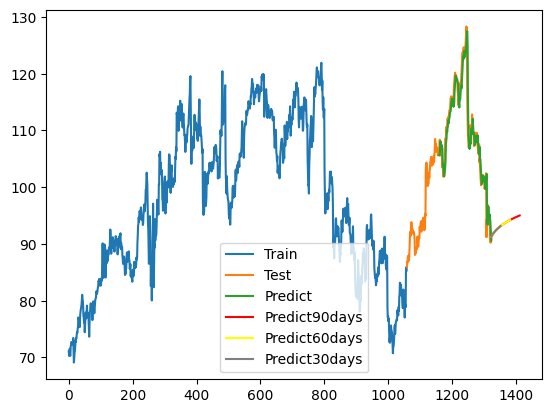

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

In [17]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mape = calculate_mape(ytest, y_pred)
test_mae = calculate_mae(ytest, y_pred)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 109.28339430510414
Testing MAPE: 16678.3912955167
Testing MAE: 108.9727835088426
